# Factor matching

The purpose of this workbook is to investigate differnetially active groundtruth factors that were picked up with TL that are not picked up with Direct.

It is of interest to see the frequency with which differentially active groundtruth factors (which come from factorization of the reference datasets) are picked up as true positives from factorizations of the target datasets.
Then GSEA is used to assess the biological relevance of these factors, with speacial interest in those picked up with transfer learning but not with direct factorization.

## Identify factors of interest

In [1]:
# libraries
library(MOFA2)
library(rhdf5)
library(rjson)
library(dplyr)
library(ggplot2)
library(RColorBrewer)
library(fgsea)
library(msigdbr)

Warning message:
“package ‘MOFA2’ was built under R version 4.2.1”



Attaching package: ‘MOFA2’


The following object is masked from ‘package:stats’:

    predict


Warning message:
“package ‘rhdf5’ was built under R version 4.2.2”
Warning message:
“package ‘rjson’ was built under R version 4.2.1”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘fgsea’ was built under R version 4.2.3”
Warning message:
“package ‘msigdbr’ was built under R version 4.2.3”


In [2]:
# import the factorization evaluation list
### which configs
TopD = 5000
TrgFullTH = '01TH'
## import the scores
FctrznEvaluation = readRDS(file.path('Results',paste0('FctrznEvaluation_',TopD,'D_',TrgFullTH,'.rds')))
## extract record of matches
factor_matches = FctrznEvaluation[['factor_matches']]
## record number of iterations per project
fctrzn_subsets = FctrznEvaluation[['FctrznEvaluationResults']] %>% 
dplyr::group_by(prjct_name) %>%
dplyr::summarise(subsets = max(ss_iteration)) %>%
as.data.frame()

In [3]:
## loop through to aggregate
match_type = character()
prjct_name = character()
fctrzn_method = character()
fctr_number = integer()

for (m in names(factor_matches)){
    for (p in names(factor_matches[[m]])){
        for (ss in names(factor_matches[[m]][[p]])){
            for (fm in names(factor_matches[[m]][[p]][[ss]])){

                if (m=='True_positives'){
                   fctr_number_tmp = factor_matches[[m]][[p]][[ss]][[fm]]
                } else {
                    fctr_number_tmp = unique(factor_matches[[m]][[p]][[ss]][[fm]]$Full)
                }

                fctr_number = c(fctr_number, fctr_number_tmp) 
                fctrzn_method = c(fctrzn_method, rep(fm, length(fctr_number_tmp)))
                prjct_name = c(prjct_name, rep(p, length(fctr_number_tmp)))
                match_type = c(match_type, rep(m, length(fctr_number_tmp)))
                
            }
        }
    }
}

factor_matches_df = data.frame(
   match_type = match_type,
   prjct_name = prjct_name,
   fctrzn_method = fctrzn_method,
   fctr_number = fctr_number 
) %>% 
dplyr::inner_join(fctrzn_subsets, by = c('prjct_name')) %>%
dplyr::mutate(subsets_percent = 1/subsets) %>%
as.data.frame()



In [4]:
## tidy up and prepare summary table
factor_matches_df$fctrzn_method[factor_matches_df$fctrzn_method=="TL_VI"]="MOTL"

factor_matches_df$groundtruth_factor = factor(
    factor_matches_df$fctr_number, 
    levels = unique(factor_matches_df$fctr_number)[order(unique(factor_matches_df$fctr_number))]
    )

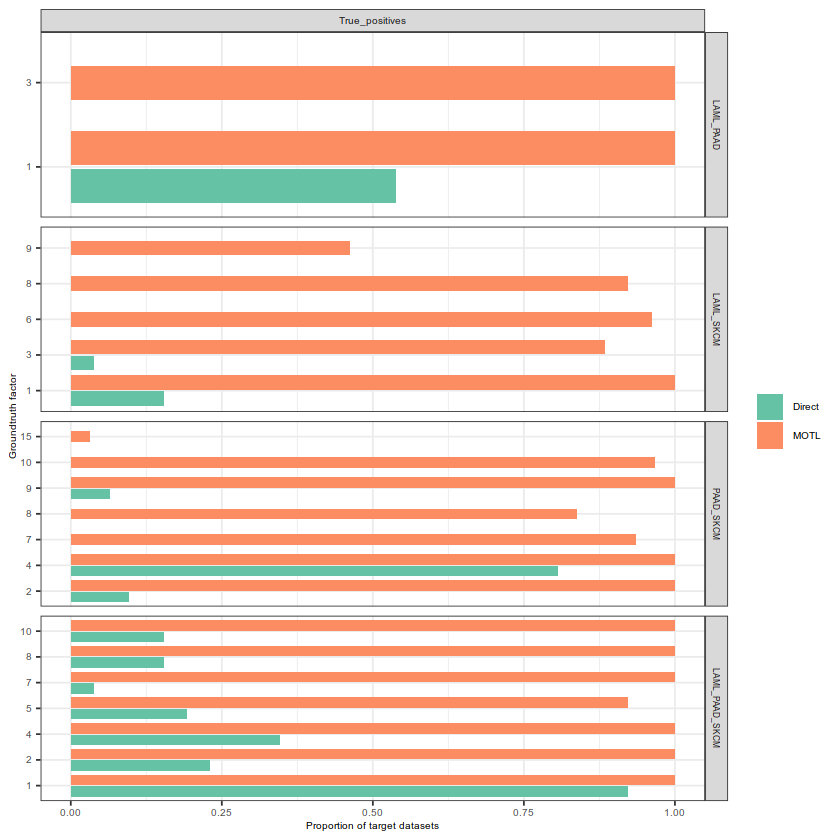

In [5]:
# summary stats
PlotPrjcts = c('LAML_PAAD','LAML_SKCM','PAAD_SKCM','LAML_PAAD_SKCM')
PlotMatches = c('True_positives')
PlotName = 'MatchedFactors_TPs_'

PlotMethods = c('Direct', 'MOTL')

DFToPlot = factor_matches_df[
    is.element(factor_matches_df$prjct_name, PlotPrjcts) &
    is.element(factor_matches_df$match_type, PlotMatches) &
    is.element(factor_matches_df$fctrzn_method, PlotMethods) 
    ,]
DFToPlot$fctrzn_method = as.factor(DFToPlot$fctrzn_method)
DFToPlot$fctrzn_method = relevel(DFToPlot$fctrzn_method, ref = 'Direct')


ggplot(data = DFToPlot, mapping = aes(
    x=groundtruth_factor, fill=fctrzn_method, weight = subsets_percent
    )) +
    geom_bar(position = position_dodge2(preserve = "single")) +
    facet_grid(factor(prjct_name, levels = PlotPrjcts) ~ match_type, scales = 'free') +
    coord_flip()+
    xlab("Groundtruth factor") +
    ylab("Proportion of target datasets") +
    theme_bw() +
    theme(
        axis.text.x = element_text(size=6),
        axis.text.y = element_text(size=6),
        strip.text.x = element_text(size=6),
        strip.text.y = element_text(size=5),
        axis.title.x = element_text(size=6),
        axis.title.y = element_text(size=6),
        legend.title = element_blank(),
        legend.text = element_text(size=6)
        ) +
    scale_fill_brewer(palette = "Set2")

ggsave(file.path('Results',paste0(PlotName,TopD,'D_',TrgFullTH,'.pdf')),
         width = 10, height = 10, units = "cm"
         )
ggsave(file.path('Results',paste0(PlotName,TopD,'D_',TrgFullTH,'.png')),
         width = 10, height = 10, units = "cm"
         )

In [8]:
# print a table
DFToTable = DFToPlot %>% 
dplyr::group_by(match_type, prjct_name, fctrzn_method, fctr_number) %>%
# dplyr::summarize(n = n()) %>%
dplyr::summarize(n = sum(subsets_percent)) %>%
    as.data.frame()

DFToTable = reshape(
    DFToTable,
    idvar = c("match_type", "prjct_name", "fctr_number"),
    timevar = "fctrzn_method",
    direction = "wide")


print(DFToTable[order(
    DFToTable$match_type,
    DFToTable$prjct_name, 
    DFToTable$fctr_number),])

write.table(DFToTable,
            file.path('Results', paste0(PlotName,TopD,'D_',TrgFullTH,'.csv')),
            quote = FALSE, sep=',', na='', row.names = FALSE, col.names = TRUE)


`summarise()` has grouped output by 'match_type', 'prjct_name',
'fctrzn_method'. You can override using the `.groups` argument.


       match_type     prjct_name fctr_number   n.Direct     n.MOTL
1  True_positives      LAML_PAAD           1 0.53846154 1.00000000
3  True_positives      LAML_PAAD           3         NA 1.00000000
4  True_positives LAML_PAAD_SKCM           1 0.92307692 1.00000000
5  True_positives LAML_PAAD_SKCM           2 0.23076923 1.00000000
6  True_positives LAML_PAAD_SKCM           4 0.34615385 1.00000000
7  True_positives LAML_PAAD_SKCM           5 0.19230769 0.92307692
8  True_positives LAML_PAAD_SKCM           7 0.03846154 1.00000000
9  True_positives LAML_PAAD_SKCM           8 0.15384615 1.00000000
10 True_positives LAML_PAAD_SKCM          10 0.15384615 1.00000000
18 True_positives      LAML_SKCM           1 0.15384615 1.00000000
19 True_positives      LAML_SKCM           3 0.03846154 0.88461538
22 True_positives      LAML_SKCM           6         NA 0.96153846
23 True_positives      LAML_SKCM           8         NA 0.92307692
24 True_positives      LAML_SKCM           9         NA 0.4615

## Inspect a factor of interest

In [3]:
## import a groundtruth factorization to inspect a factor
Prjct = 'LAML_PAAD'
TrgFullK = 100
TrgFullDir = file.path(
    paste0('Trg_',Prjct,'_Full_',TopD,'D'), 
    paste0('Fctrzn_',TrgFullK,'K_',TrgFullTH)
    )
InputModel = file.path(TrgFullDir,"Model.hdf5")
TrgFull_Fctrzn = load_model(file = InputModel)

print(colnames(TrgFull_Fctrzn@expectations$W[['mRNA']]))

[1] "Factor1" "Factor2" "Factor3" "Factor4" "Factor5" "Factor6"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



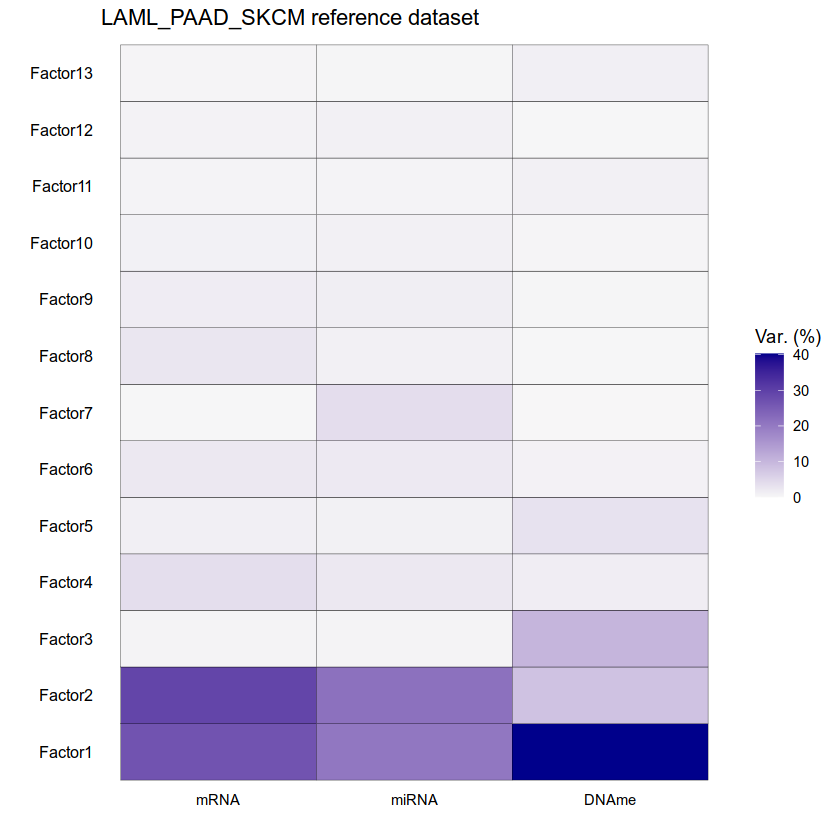

In [13]:
# plot variance explained by the factors and save plot
varexp_title = paste0(Prjct,' reference dataset')
varexp = plot_variance_explained(TrgFull_Fctrzn) + ggtitle(varexp_title)
varexp
ggsave(filename = file.path('Results',
                   paste0('VarExpl_',Prjct,'_',TopD,'D_',TrgFullK,'K_',TrgFullTH,'.pdf')),
                   plot = varexp
        #            ,
        #  width = 10, height = 10, units = "cm"
         )
ggsave(filename = file.path('Results',
                   paste0('VarExpl_',Prjct,'_',TopD,'D_',TrgFullK,'K_',TrgFullTH,'.png')),
                   plot = varexp
        #            ,
        #  width = 10, height = 10, units = "cm"
         )

In [7]:
# print variance explained by the factors and save csv
varexp = TrgFull_Fctrzn@cache$variance_explained$r2_per_factor[[1]]
print(varexp)
# trick to export rownames to csv
colnames(varexp)[1] = paste0('Factor',',',colnames(varexp)[1])
write.table(varexp,
            file.path(
                'Results',
                paste0('VarExpl_',Prjct,'_',TopD,'D_',TrgFullK,'K_',TrgFullTH,'.csv')
                ),
            quote = FALSE, sep=',', na='', row.names = TRUE, col.names = TRUE)


              mRNA      miRNA      DNAme
Factor1 75.5200497 56.1671612 62.1252966
Factor2  0.2915616  0.3420876  6.5034200
Factor3  2.1951990  2.2555125  2.6377356
Factor4  1.1580766  0.9029641  4.1245259
Factor5  1.3388695  1.1544682  0.4329096
Factor6  0.8634785  0.7287511  1.1692885


[1] 0.8312139

[1] -0.7376476

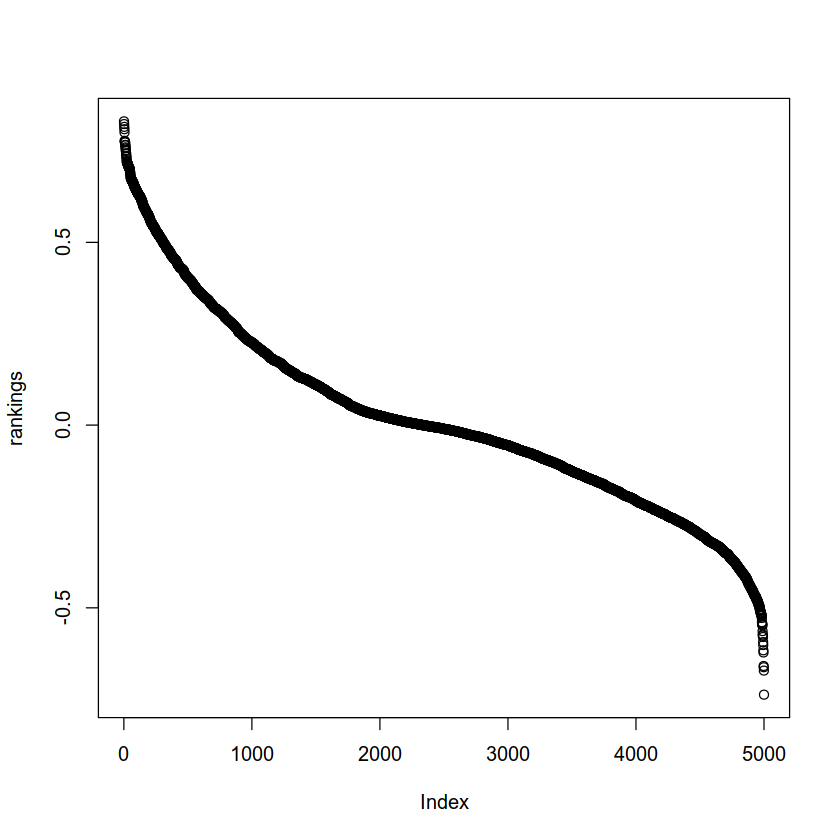

In [18]:
# Get the mRNA weight matrix
W_mRNA = TrgFull_Fctrzn@expectations$W[['mRNA']]
# truncate row names
rownames(W_mRNA) = substr(rownames(W_mRNA),1,regexpr('[.]',rownames(W_mRNA))-1)
# scale feature values across the factors?
ScaleW = function(x) {
  x/norm(matrix(x),type="F")
}
W_mRNA = t(apply(W_mRNA,1, ScaleW))

# pick a factor to use as the ranking vector
rankings = W_mRNA[,10]
names(rankings) = rownames(W_mRNA)
rankings = sort(rankings, decreasing = TRUE)
# check the rankings
max(rankings)
min(rankings)
plot(rankings)


In [6]:
# what are the options for the gene sets?
msigdbr_species()
msigdbr_collections()

species_name,species_common_name
<chr>,<chr>
Anolis carolinensis,"Carolina anole, green anole"
Bos taurus,"bovine, cattle, cow, dairy cow, domestic cattle, domestic cow, ox, oxen"
Caenorhabditis elegans,NA
Canis lupus familiaris,"dog, dogs"
Danio rerio,"leopard danio, zebra danio, zebra fish, zebrafish"
Drosophila melanogaster,fruit fly
Equus caballus,"domestic horse, equine, horse"
Felis catus,"cat, cats, domestic cat"
Gallus gallus,"bantam, chicken, chickens, Gallus domesticus"


gs_cat,gs_subcat,num_genesets
<chr>,<chr>,<int>
C1,,299
C2,CGP,3384
C2,CP,29
C2,CP:BIOCARTA,292
C2,CP:KEGG,186
C2,CP:PID,196
C2,CP:REACTOME,1615
C2,CP:WIKIPATHWAYS,664
C3,MIR:MIR_Legacy,221


In [12]:
## get a collection and create a list for fsgea
gene_sets = msigdbr(
    species = "Homo sapiens", 
    category = "C5", 
    subcategory = "GO:CC"
)

# colnames(gene_sets)
# print(head(gene_sets$ensembl_gene))

gene_sets = gene_sets %>% 
dplyr::distinct(gs_name, ensembl_gene) %>% 
as.data.frame()

## check output and overlap

overlap_genes = names(rankings)[is.element(names(rankings),gene_sets$ensembl_gene)]
length(overlap_genes)
print(head(gene_sets))

## create a list for fsgea

gene_sets = split(x = gene_sets$ensembl_gene, f = gene_sets$gs_name)
print(length(gene_sets))
head(names(gene_sets))

[1] 2761

               gs_name    ensembl_gene
1 GOCC_90S_PRERIBOSOME ENSG00000165733
2 GOCC_90S_PRERIBOSOME ENSG00000261236
3 GOCC_90S_PRERIBOSOME ENSG00000285301
4 GOCC_90S_PRERIBOSOME ENSG00000275464
5 GOCC_90S_PRERIBOSOME ENSG00000119285
6 GOCC_90S_PRERIBOSOME ENSG00000177971
[1] 1006


[1] "GOCC_90S_PRERIBOSOME"                    
[2] "GOCC_9PLUS0_NON_MOTILE_CILIUM"           
[3] "GOCC_9PLUS2_MOTILE_CILIUM"               
[4] "GOCC_A_BAND"                             
[5] "GOCC_ACETYLCHOLINE_GATED_CHANNEL_COMPLEX"
[6] "GOCC_ACROSOMAL_MEMBRANE"

In [19]:
## run fsgea
fgseaRes = fgsea(
    pathways = gene_sets,
    stats = rankings,
    minSize = 15,
    maxSize = 500)

In [20]:
## Quick inspection of GOCC_T_CELL_RECEPTOR_COMPLEX
fgseaRes$leadingEdge[fgseaRes$pathway=="GOCC_T_CELL_RECEPTOR_COMPLEX"]

[[1]]
 [1] "ENSG00000237254" "ENSG00000211772" "ENSG00000160654" "ENSG00000277734"
 [5] "ENSG00000167286" "ENSG00000282939" "ENSG00000172116" "ENSG00000198851"
 [9] "ENSG00000211795" "ENSG00000211786" "ENSG00000211752" "ENSG00000211788"
[13] "ENSG00000211778" "ENSG00000211777" "ENSG00000211710" "ENSG00000211745"
[17] "ENSG00000211721" "ENSG00000232869" "ENSG00000211797" "ENSG00000163519"
[21] "ENSG00000211747" "ENSG00000211753" "ENSG00000211789" "ENSG00000278030"
[25] "ENSG00000211801" "ENSG00000211728" "ENSG00000153563" "ENSG00000211694"
[29] "ENSG00000211746" "ENSG00000141293" "ENSG00000211785" "ENSG00000211716"
[33] "ENSG00000211799" "ENSG00000211734" "ENSG00000115085" "ENSG00000226660"
[37] "ENSG00000276557" "ENSG00000230099" "ENSG00000275791" "ENSG00000276953"
[41] "ENSG00000211706"

In [12]:
## check results
fgseaRes = fgseaRes %>% 
            dplyr::select(pathway, padj, ES, NES, size) %>% 
            as.data.frame()

fgseaRes = fgseaRes[fgseaRes$padj<0.01 & !is.na(fgseaRes$padj),]

print(head(fgseaRes))

[1] 111
                                        pathway         padj         ES
1616                    GOBP_SYNAPTIC_SIGNALING 2.767033e-05  0.4379358
1626                  GOBP_TISSUE_MORPHOGENESIS 3.861538e-05 -0.5400216
1641                      GOBP_TUBE_DEVELOPMENT 1.638597e-03 -0.4736871
1643                    GOBP_TUBE_MORPHOGENESIS 5.126693e-04 -0.4954435
1658               GOBP_VASCULATURE_DEVELOPMENT 2.737917e-03 -0.4943321
1668 GOBP_VESICLE_MEDIATED_TRANSPORT_IN_SYNAPSE 1.263238e-03  0.6389455
           NES size
1616  1.751244  179
1626 -1.565065  226
1641 -1.392826  369
1643 -1.451267  307
1658 -1.445121  272
1668  1.974441   41


## Loop to save significant pathways

The code before this is used to identify factors of interest and explore fgsea outputs.
This code should be run after restarting the kernel. It will loop through specified projects, factors and pathways and run fgsea. The final output is a dataframe to be saved as a csv

In [1]:
# libraries
library(MOFA2)
library(rhdf5)
library(rjson)
library(dplyr)
library(ggplot2)
library(RColorBrewer)
library(fgsea)
library(msigdbr)

Warning message:
“package ‘MOFA2’ was built under R version 4.2.1”



Attaching package: ‘MOFA2’


The following object is masked from ‘package:stats’:

    predict


Warning message:
“package ‘rhdf5’ was built under R version 4.2.2”
Warning message:
“package ‘rjson’ was built under R version 4.2.1”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘fgsea’ was built under R version 4.2.3”
Warning message:
“package ‘msigdbr’ was built under R version 4.2.3”


In [2]:
## common factorization parameter values
TopD = 5000
TrgFullTH = '01TH'
TrgFullK = 100

## factors to test 'LAML_PAAD','LAML_SKCM','PAAD_SKCM','LAML_PAAD_SKCM'
## Differentially active groundtruth factors picked up from T factorization
## that explained at least 0.01 of variance in R

FactorsToTest = list(
  LAML_PAAD = data.frame(
    k = c(1, 3),
    mRNAvar = c(75.5, 2.2),
    DirectFreq = c('middle','low')
  ),
  LAML_SKCM = data.frame(
    k = c(1, 3, 8, 9),
    mRNAvar = c(50.2, 3.9, 1.6, 3.0),
    DirectFreq = c('low','low','low', 'low')
  ),
  PAAD_SKCM = data.frame(
    k = c(2, 4, 7, 9, 10, 15),
    mRNAvar = c(35.6, 1.2, 5.1, 2.2, 2.1, 1.6),
    DirectFreq = c('low','high','low','low','low', 'low')
  ),
  LAML_PAAD_SKCM = data.frame(
    k = c(1, 2, 4, 5, 8),
    mRNAvar = c(26.7, 29.2, 3.9, 1.2, 2.6),
    DirectFreq = c('high','low','middle','low','low')
  )
)

## the genesets to test
GenesetsToTest = data.frame(
  category = c("C2", "C2", "C5", "C5"),
  subcategory = c("CP:KEGG", "CP:REACTOME", "GO:BP", "GO:CC")
)


In [ ]:
## empty list to store results
SigGeneSets = vector("list")

# scaling function
ScaleW = function(x) {
x/norm(matrix(x),type="F")
}

for (Prjct in names(FactorsToTest)){

    # import the groundtruth factorization
    TrgFullDir = file.path(
    paste0('Trg_',Prjct,'_Full_',TopD,'D'), 
    paste0('Fctrzn_',TrgFullK,'K_',TrgFullTH)
    )
    InputModel = file.path(TrgFullDir,"Model.hdf5")
    TrgFull_Fctrzn = load_model(file = InputModel) 

    # Get the mRNA weight matrix
    W_mRNA = TrgFull_Fctrzn@expectations$W[['mRNA']]
    # truncate row names
    rownames(W_mRNA) = substr(
        rownames(W_mRNA),
        1,
        regexpr('[.]',rownames(W_mRNA))-1
        )
    # scale the weights
    W_mRNA = t(apply(W_mRNA,1, ScaleW))

    for (ftt in 1:nrow(FactorsToTest[[Prjct]])){

        k = FactorsToTest[[Prjct]]$k[ftt]
        mRNAvar = FactorsToTest[[Prjct]]$mRNAvar[ftt]
        DirectFreq = FactorsToTest[[Prjct]]$DirectFreq[ftt]

        # pick a factor to use as the ranking vector
        rankings = W_mRNA[,k]
        names(rankings) = rownames(W_mRNA)

        # test for different geneset collections
        for (gstt in 1:nrow(GenesetsToTest)){
            # get the genesets for a selected collection
            category = GenesetsToTest$category[gstt]
            subcategory = GenesetsToTest$subcategory[gstt]
            gene_sets = msigdbr(
                species = "Homo sapiens", 
                category = category, 
                subcategory = subcategory
                )
                
            gene_sets = gene_sets %>% 
            dplyr::distinct(gs_name, ensembl_gene) %>% 
            as.data.frame()

            gene_sets = split(
                x = gene_sets$ensembl_gene, 
                f = gene_sets$gs_name
                )
            # set seed
            Seed = 1234567
            mode(Seed) = 'integer'
            set.seed(Seed)

            # run fgsea
            fgseaRes = fgsea(
                pathways = gene_sets,
                stats = rankings,
                minSize = 15,
                maxSize = 500
                )
            
            fgseaRes = fgseaRes %>% 
            dplyr::select(pathway, padj, ES, NES, size) %>% 
            as.data.frame()
            
            fgseaRes = fgseaRes[fgseaRes$padj<0.01 & !is.na(fgseaRes$padj),]
            
            fgseaRes$Prjct = rep(Prjct,nrow(fgseaRes))
            fgseaRes$k = rep(k,nrow(fgseaRes))
            fgseaRes$mRNAvar = rep(mRNAvar,nrow(fgseaRes))
            fgseaRes$DirectFreq = rep(DirectFreq,nrow(fgseaRes))
            fgseaRes$subcategory = rep(subcategory,nrow(fgseaRes))

            # add to list of results
            SigGeneSets[[paste0(c(Prjct,k,subcategory),collapse = ';')]] = fgseaRes
            # tidy up
            rm(list=c("fgseaRes", "gene_sets"))
            invisible(gc())

        } 
        # tidy up
        rm(list=c("rankings"))
        invisible(gc())              
    } 
    # tidy up
    rm(list=c("TrgFull_Fctrzn", "W_mRNA"))
    invisible(gc())   
}

## create a single dataframe
SigGeneSetsDF = do.call(rbind, SigGeneSets)
## export as csv
write.table(SigGeneSetsDF,
            file.path('Results','SigGeneSets.csv'),
            quote = FALSE, sep=',', na='', row.names = FALSE, col.names = TRUE)
